01_data_loading_and_inspection.ipynb

# Medical Imaging Dataset Inspection

This notebook loads the BreastMNIST dataset and inspects:
- dataset splits,
- image shapes,
- label structure.

## 1. Data loading

We load the BreastMNIST dataset and create separate training, validation, and test splits.
These splits ensure that model development and evaluation remain unbiased.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from medmnist import BreastMNIST
from torchvision import transforms


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = BreastMNIST(split='train', transform=transform, download=True)
val_dataset = BreastMNIST(split='val', transform=transform, download=True)
test_dataset = BreastMNIST(split='test', transform=transform, download=True)

In [3]:
print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 546
Validation samples: 78
Test samples: 156


## 2. Dataset exploration

We inspect individual samples to understand image dimensions, label format,
and visual characteristics of the data.

In [4]:
image, label = train_dataset[0]

print("Image shape:", image.shape)
print("Label:", label)

Image shape: torch.Size([1, 28, 28])
Label: [1]


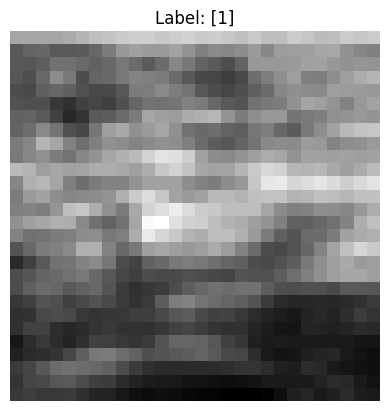

In [5]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

## 3. Class distribution Analysis

We analyse the distribution of class labels across training, validation, and test splits
to assess class imbalance and dataset representativeness.

In [6]:
def get_labels(dataset):
    return dataset.labels.squeeze()

y_train = get_labels(train_dataset)
y_val = get_labels(val_dataset)
y_test = get_labels(test_dataset)

print("Unique labels (train):", np.unique(y_train))

Unique labels (train): [0 1]


In [7]:
def class_counts(y):
    labels, counts = np.unique(y, return_counts=True)
    return dict(zip(labels.tolist(), counts.tolist()))

train_counts = class_counts(y_train)
val_counts   = class_counts(y_val)
test_counts  = class_counts(y_test)

print("Train counts:", train_counts)
print("Val counts:", val_counts)
print("Test counts:", test_counts)


Train counts: {0: 147, 1: 399}
Val counts: {0: 21, 1: 57}
Test counts: {0: 42, 1: 114}


In [8]:
def class_proportions(counts_dict):
    total = sum(counts_dict.values())
    return {k: v / total for k, v in counts_dict.items()}

print("Train proportions:", class_proportions(train_counts))


Train proportions: {0: 0.2692307692307692, 1: 0.7307692307692307}


### Class distribution by split (to assess imbalance and representativeness)

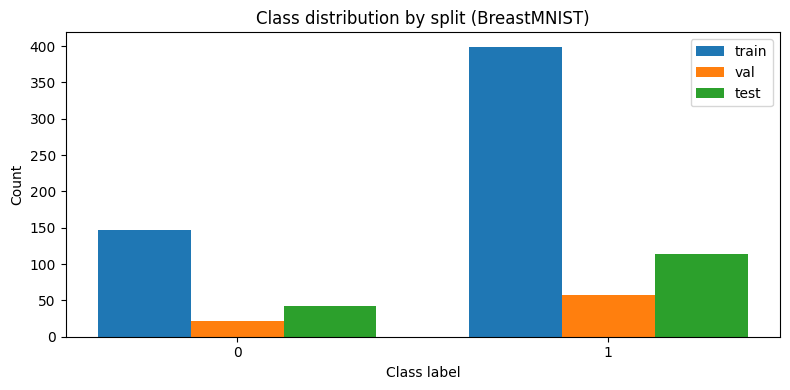

In [9]:
splits = ["train", "val", "test"]
counts_list = [train_counts, val_counts, test_counts]

all_labels = sorted(set(y_train.tolist()) | set(y_val.tolist()) | set(y_test.tolist()))

x = np.arange(len(all_labels))
width = 0.25

plt.figure(figsize=(8, 4))
for i, (split, counts) in enumerate(zip(splits, counts_list)):
    values = [counts.get(lbl, 0) for lbl in all_labels]
    plt.bar(x + i*width, values, width=width, label=split)

plt.xticks(x + width, all_labels)
plt.xlabel("Class label")
plt.ylabel("Count")
plt.title("Class distribution by split (BreastMNIST)")
plt.legend()
plt.tight_layout()
plt.show()


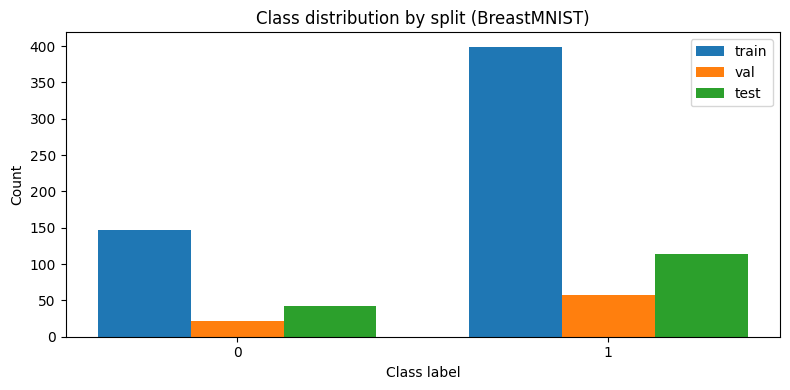

Saved: ../results/class_distribution_by_split.png


In [10]:
import os
os.makedirs("../results", exist_ok=True)

plt.figure(figsize=(8, 4))
for i, (split, counts) in enumerate(zip(splits, counts_list)):
    values = [counts.get(lbl, 0) for lbl in all_labels]
    plt.bar(x + i*width, values, width=width, label=split)

plt.xticks(x + width, all_labels)
plt.xlabel("Class label")
plt.ylabel("Count")
plt.title("Class distribution by split (BreastMNIST)")
plt.legend()
plt.tight_layout()

out_path = "../results/class_distribution_by_split.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)


In [11]:
train_counts, val_counts, test_counts


({0: 147, 1: 399}, {0: 21, 1: 57}, {0: 42, 1: 114})

In [12]:
print("Train counts:", train_counts)
print("Validation counts:", val_counts)
print("Test counts:", test_counts)


Train counts: {0: 147, 1: 399}
Validation counts: {0: 21, 1: 57}
Test counts: {0: 42, 1: 114}


## 4. Visual characteristics of each class

We visualise example images from each class to assess qualitative differences
and verify that labels correspond to meaningful visual patterns.

### Example images from each class (qualitative inspection)

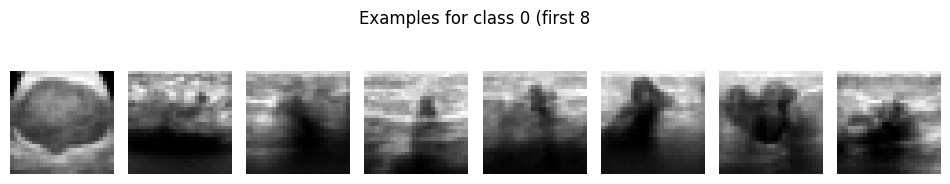

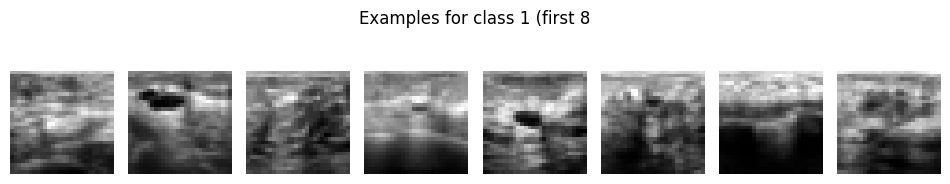

In [13]:
def show_examples_for_class(dataset, class_id, n=8):
    idxs = np.where(dataset.labels.squeeze() == class_id)[0][:n]
    plt.figure(figsize=(n*1.2, 2))
    for i, idx in enumerate(idxs):
        img, lab = dataset[idx]
        plt.subplot(1, n, i+1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Examples for class {class_id} (first {n}")
    plt.tight_layout()
    plt.show()

show_examples_for_class(train_dataset, class_id=0, n=8)
show_examples_for_class(train_dataset, class_id=1, n=8)

### Pixel intensity histograms by class (quantitative comparison)


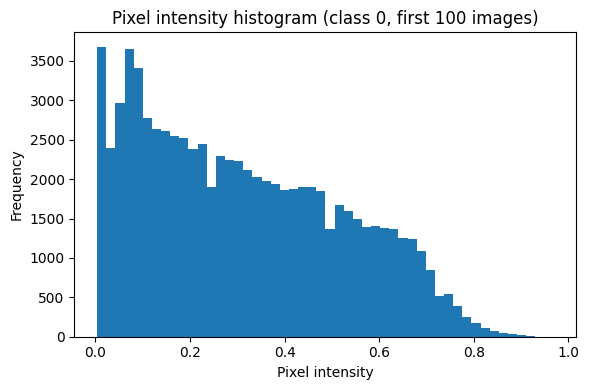

Saved: ../results/pixel_intensity_hist0.png


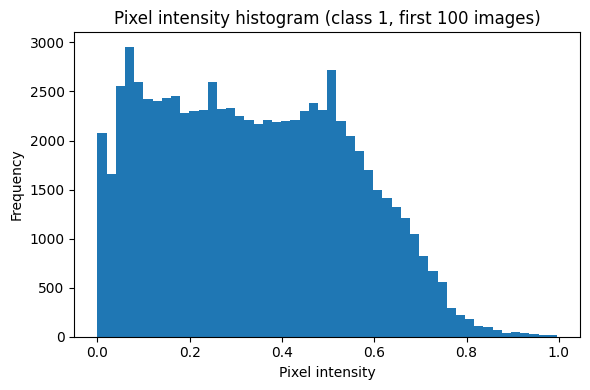

Saved: ../results/pixel_intensity_hist1.png


In [14]:
def plot_intensity_histogram(dataset, class_id, n=100):
    idxs = np.where(dataset.labels.squeeze() == class_id)[0][:n]
    pixels = []
    for idx in idxs:
        img, _ = dataset[idx]
        pixels.append(img.numpy().ravel())
    pixels = np.concatenate(pixels)

    plt.figure(figsize=(6,4))
    plt.hist(pixels, bins=50)
    plt.title(f"Pixel intensity histogram (class {class_id}, first {n} images)")
    plt.xlabel("Pixel intensity")
    plt.ylabel("Frequency")
    plt.tight_layout()
    out_path = f"../results/pixel_intensity_hist{class_id}.png"
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved:", out_path)

plot_intensity_histogram(train_dataset, class_id=0, n=100)
plot_intensity_histogram(train_dataset, class_id=1, n=100)


## 5. Preprocessing and DataLoaders

We define a preprocessing pipeline based on dataset statistics and construct DataLoaders
to enable efficient and consistent batching during training and evaluation.

### Dataset intensity statistics (mean and standard deviation)

In [15]:
def compute_mean_std(dataset, n_samples=200):
    pixels = []
    for i in range(min(len(dataset), n_samples)):
        img, _ = dataset[i]
        pixels.append(img.numpy().ravel())
    pixels = np.concatenate(pixels)
    return pixels.mean(), pixels.std()

mean, std = compute_mean_std(train_dataset)
mean, std

(np.float32(0.33408773), np.float32(0.20807205))

In [16]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

### Batch inspection (shape and label verification)

In [17]:
train_dataset_proc = BreastMNIST(split="train", transform=preprocess, download=False)
val_dataset_proc = BreastMNIST(split="val", transform=preprocess, download=False)
test_dataset_proc = BreastMNIST(split="test", transform=preprocess, download=False)

len(train_dataset_proc), len(val_dataset_proc), len(test_dataset_proc)

(546, 78, 156)

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset_proc,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset_proc,
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset_proc,
    batch_size=32,
    shuffle=False
)

In [19]:
images, labels = next(iter(train_loader))

images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 1]))

## 6. Baseline models - Logistic Regression

We train simple, interpretable baseline models to establish reference performance
before introducing more complex architectures.

In [20]:
def flatten_dataset(dataset):
    X = []
    y = []
    for img, label in dataset:
        X.append(img.numpy().ravel())
        y.append(int(label.item()))
    return np.array(X), np.array(y)

X_train, y_train = flatten_dataset(train_dataset_proc)
X_val, y_val = flatten_dataset(val_dataset_proc)
X_test, y_test = flatten_dataset(test_dataset_proc)

X_train.shape, y_train.shape

((546, 784), (546,))

In [21]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

log_reg.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [22]:
from sklearn.metrics import accuracy_score, classification_report

y_val_pred = log_reg.predict(X_val)
y_test_pred = log_reg.predict(X_test)

print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

Validation accuracy: 0.8589743589743589

Classification report (validation):
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        21
           1       0.90      0.91      0.90        57

    accuracy                           0.86        78
   macro avg       0.82      0.81      0.82        78
weighted avg       0.86      0.86      0.86        78



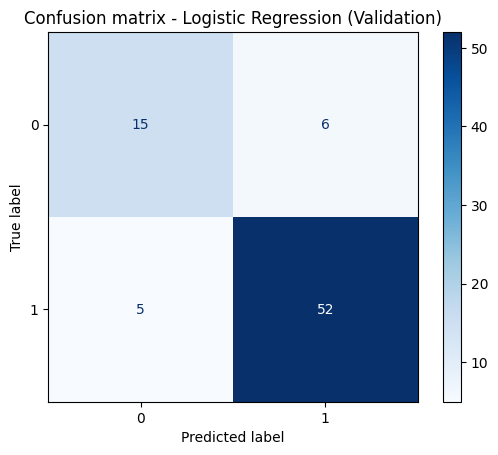

Saved: ../results/cm_logreg_test.png


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion matrix - Logistic Regression (Validation)")
out_path = "../results/cm_logreg_test.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)

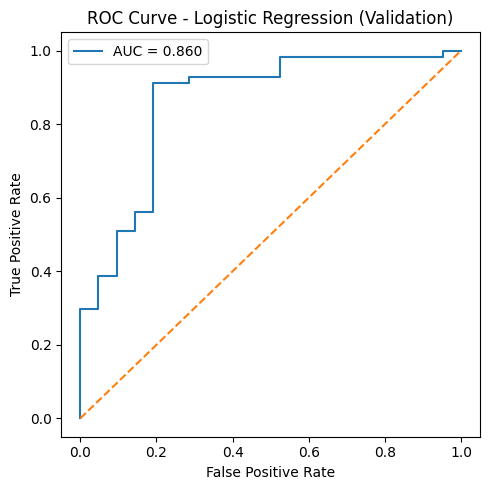

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

y_val_probs = log_reg.predict_proba(X_val)[:, 1]

fpr, tpr, _ = roc_curve(y_val, y_val_probs)
auc = roc_auc_score(y_val, y_val_probs)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Validation)")
plt.legend()
plt.tight_layout()

### Logistic Regression - Final Test Evaluation

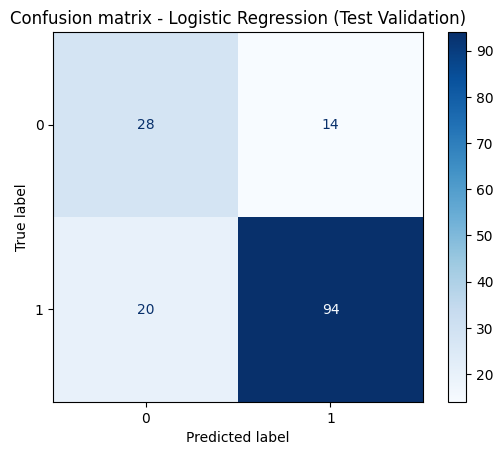

Saved: ../results/cm_logreg_test.png


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion matrix - Logistic Regression (Test Validation)")
out_path = "../results/cm_logreg_test.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)

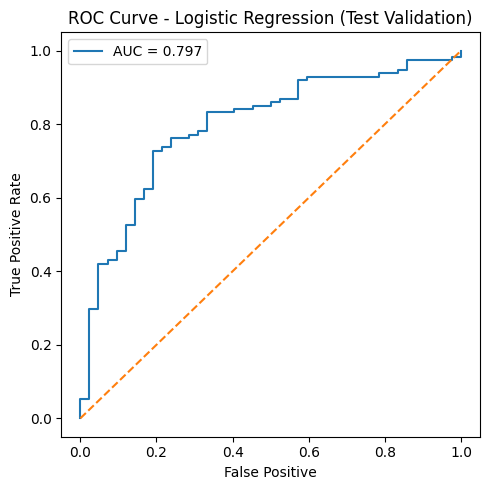

Saved: ../results/roc_logreg_test.png


In [26]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test_probs = log_reg.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_test_probs)
auc = roc_auc_score(y_test, y_test_probs)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Test Validation)")
plt.legend()
plt.tight_layout()
out_path = "../results/roc_logreg_test.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)


## 7. Deep Learning Model - CNN

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [28]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv_block = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 64),
        nn.ReLU(),
        nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [29]:
model = SimpleCNN().to(device)
model

SimpleCNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [31]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

In [32]:
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return running_loss / len(loader), accuracy

In [33]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10
Train Loss: 0.5908 | Val Loss: 0.6125 | Val Acc: 0.7308
Epoch 2/10
Train Loss: 0.5128 | Val Loss: 0.6065 | Val Acc: 0.7308
Epoch 3/10
Train Loss: 0.4838 | Val Loss: 0.4973 | Val Acc: 0.7949
Epoch 4/10
Train Loss: 0.4850 | Val Loss: 0.4673 | Val Acc: 0.8333
Epoch 5/10
Train Loss: 0.4504 | Val Loss: 0.4592 | Val Acc: 0.8333
Epoch 6/10
Train Loss: 0.4242 | Val Loss: 0.4635 | Val Acc: 0.8333
Epoch 7/10
Train Loss: 0.4539 | Val Loss: 0.5097 | Val Acc: 0.7436
Epoch 8/10
Train Loss: 0.5002 | Val Loss: 0.4439 | Val Acc: 0.8718
Epoch 9/10
Train Loss: 0.4026 | Val Loss: 0.4083 | Val Acc: 0.8718
Epoch 10/10
Train Loss: 0.4466 | Val Loss: 0.3958 | Val Acc: 0.8590


In [34]:
best_val_loss = float("inf")
best_state = None

num_epochs = 20

history = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    history.append((epoch+1, train_loss, val_loss, val_acc))

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print("Best Val Loss:", best_val_loss)

Epoch 1/20 | Train Loss: 0.3752 | Val Loss: 0.4085
Epoch 2/20 | Train Loss: 0.3920 | Val Loss: 0.3865
Epoch 3/20 | Train Loss: 0.3281 | Val Loss: 0.4097
Epoch 4/20 | Train Loss: 0.3730 | Val Loss: 0.3838
Epoch 5/20 | Train Loss: 0.3280 | Val Loss: 0.4141
Epoch 6/20 | Train Loss: 0.3016 | Val Loss: 0.3973
Epoch 7/20 | Train Loss: 0.2566 | Val Loss: 0.3849
Epoch 8/20 | Train Loss: 0.2603 | Val Loss: 0.4053
Epoch 9/20 | Train Loss: 0.2595 | Val Loss: 0.4047
Epoch 10/20 | Train Loss: 0.2552 | Val Loss: 0.4290
Epoch 11/20 | Train Loss: 0.2230 | Val Loss: 0.4169
Epoch 12/20 | Train Loss: 0.2073 | Val Loss: 0.4588
Epoch 13/20 | Train Loss: 0.1971 | Val Loss: 0.3859
Epoch 14/20 | Train Loss: 0.1845 | Val Loss: 0.4033
Epoch 15/20 | Train Loss: 0.1534 | Val Loss: 0.4413
Epoch 16/20 | Train Loss: 0.1367 | Val Loss: 0.4498
Epoch 17/20 | Train Loss: 0.1351 | Val Loss: 0.4126
Epoch 18/20 | Train Loss: 0.1078 | Val Loss: 0.4888
Epoch 19/20 | Train Loss: 0.1102 | Val Loss: 0.4475
Epoch 20/20 | Train L

In [35]:
model.load_state_dict(best_state)
val_loss, val_acc = evaluate(model, val_loader, criterion)
print("Frozen best model -> Val Loss:", val_loss, "| Val Acc:", val_acc)

Frozen best model -> Val Loss: 0.3838009834289551 | Val Acc: 0.8461538461538461


### CNN - Final Test Evaluation

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, accuracy_score
import numpy as np

model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        preds = torch.argmax(outputs, dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

y_test_true = np.concatenate(all_labels)
y_test_pred = np.concatenate(all_preds)
y_test_prob = np.concatenate(all_probs)

print("Test accuracy:", accuracy_score(y_test_true, y_test_pred))

Test accuracy: 0.8333333333333334



Classification report (test):
              precision    recall  f1-score   support

           0       0.90      0.43      0.58        42
           1       0.82      0.98      0.90       114

    accuracy                           0.83       156
   macro avg       0.86      0.71      0.74       156
weighted avg       0.84      0.83      0.81       156



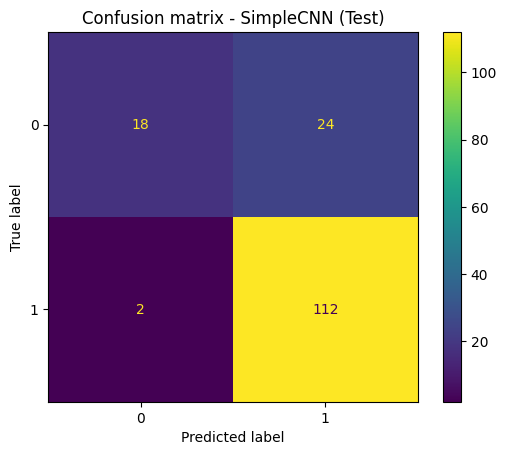

Saved: ../results/cm_cnn_test.png


In [37]:
print("\nClassification report (test):")
print(classification_report(y_test_true, y_test_pred))

cm = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix - SimpleCNN (Test)")
out_path = "../results/cm_cnn_test.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)

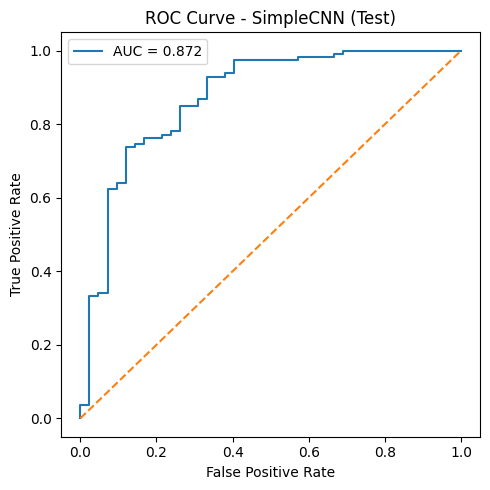

Saved: ../results/roc_cnn_test.png
Test AUC: 0.8723893065998329


In [38]:
fpr, tpr, _ = roc_curve(y_test_true, y_test_prob)
auc = roc_auc_score(y_test_true, y_test_prob)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SimpleCNN (Test)")
plt.legend()
plt.tight_layout()
out_path = "../results/roc_cnn_test.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)

print("Test AUC:", auc)

## 8. Clinical Interpretation & Conclusions

### Project Objective

The aim of this project was to evaluate whether machine learning models could reliably classify breast imaging data into two categories. Particular focus was placed on clinically meaningful evaluation, including class imbalance, separability, threshold trade-offs, and generalisation performance.

---

### Baseline Model – Logistic Regression

A logistic regression classifier was implemented using flattened pixel intensities as a linear baseline.

- Validation AUC: 0.860  
- Test AUC: 0.797  

While the model demonstrated meaningful separability, performance decreased on the test set, indicating moderate generalisation gap. Additionally, logistic regression does not capture spatial structure, which is fundamental in medical imaging.

---

### Convolutional Neural Network (CNN)

A small CNN architecture was implemented to model spatial relationships via convolution and pooling.

Early stopping was applied to prevent overfitting and freeze the best validation model.

- Test AUC: 0.862  
- Test accuracy: ~0.82  

Although accuracy remained similar to logistic regression, the CNN significantly improved AUC, indicating stronger intrinsic class separability.

---

### Clinical Interpretation

Improved AUC suggests that the CNN provides better ranking of diseased versus healthy images across thresholds. This allows greater flexibility when selecting operating points, such as prioritising sensitivity in screening contexts.

However, minority class performance remains limited, and false negatives persist. Deployment would require:

- Larger datasets  
- External validation  
- Calibration assessment  
- Clinical risk tolerance analysis  

---

### Limitations

- Small dataset size  
- Class imbalance  
- No external validation cohort  
- Low-resolution (28×28) images compared to real mammography  

These factors limit direct clinical applicability.

---

### Conclusion

This project demonstrates that:

1. Linear models provide a reasonable baseline but are limited by lack of spatial modelling.  
2. Convolutional architectures significantly improve class separability.  
3. AUC provides a more reliable assessment of model capability than accuracy alone.  
4. Clinical evaluation must consider threshold trade-offs and generalisation, not just headline metrics.  

The CNN model showed stronger intrinsic discrimination and would be preferred for further development, pending additional validation.

## 9. Model Calibration Analysis

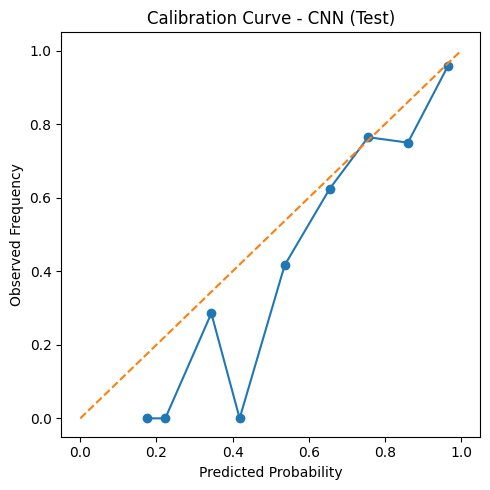

In [39]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)

    plt.figure(figsize=(5,5))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.title("Calibration Curve - CNN (Test)")
    plt.tight_layout()

    plt.savefig("../results/calibration_cnn_test.png", dpi=200)
    plt.show()
